<a href="https://colab.research.google.com/github/Sagar-modelling/EAST-CRNN_OCR/blob/main/EAST%2BCRNN_OCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
!pip install tensorflow==1.14

In [28]:
!pip install opencv-python==4.4.0.40

In [29]:
from google.colab.patches import cv2_imshow
import numpy as np
import cv2

In [30]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [31]:
!tar -xzvf "/content/gdrive/MyDrive/frozen_east_text_detection.tar.gz"

frozen_east_text_detection.pb


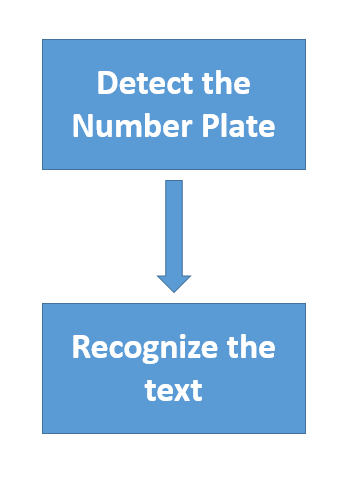

In [32]:
img = cv2.imread('/content/OCR_LNP.png')
cv2_imshow(img)

In [33]:
# Download the EAST model and Load it
model = cv2.dnn.readNet('/content/frozen_east_text_detection.pb')
model1 = cv2.dnn.readNet('/content/gdrive/MyDrive/crnn.onnx')

In [34]:
# ## Prepare the image
# use multiple of 32 to set the new img shape
height, width, _ = img.shape
new_height = (height//32)*32
new_width = (width//32)*32
print(new_height, new_width)

480 352


In [35]:
# get the ratio change in width and height
h_ratio = height/new_height
w_ratio = width/new_width
print(h_ratio, w_ratio)

1.025 1.0227272727272727


In [36]:
blob = cv2.dnn.blobFromImage(img, 1, (new_width, new_height),(123.68, 116.78, 103.94), True, False)

In [37]:
model.setInput(blob)

In [38]:
model.getUnconnectedOutLayersNames() #get names of output layers that calculate geometry maps(concat_3) and scores(Conv_7) respectively.

['feature_fusion/concat_3', 'feature_fusion/Conv_7/Sigmoid']

In [39]:
(geometry, scores) = model.forward(model.getUnconnectedOutLayersNames()) ## -------------  Forward Propagation  -------------

In [40]:
(geometry).shape

(1, 5, 120, 88)

In [41]:
(scores).shape

(1, 1, 120, 88)

In [42]:
# ## Post-Processing
rectangles = [] #list 1
confidence_score = [] #list 2
for i in range(geometry.shape[2]): #iterate each pixel row by row to construct counding boxes. shape[2] pixel value = 208
    for j in range(0, geometry.shape[3]):  #shape[3] pixel value =192
        
        if scores[0][0][i][j] < 0.1:  #if score of pixel is less than threshold then we don't consider the pixel and we continue
            continue
            #otherwise obtain bounding box coordinates as follows
        bottom_x = int(j*4 + geometry[0][1][i][j])
        bottom_y = int(i*4 + geometry[0][2][i][j])
        

        top_x = int(j*4 - geometry[0][3][i][j])
        top_y = int(i*4 - geometry[0][0][i][j])
        
        rectangles.append((top_x, top_y, bottom_x, bottom_y))
        confidence_score.append(float(scores[0][0][i][j]))

In [43]:
from imutils.object_detection import non_max_suppression

In [44]:
# use Non-max suppression to get the required rectangles
import numpy as np
fin_boxes = non_max_suppression(np.array(rectangles), probs=confidence_score, overlapThresh=0.5) #this NMS function only works for non roated text boxes.
fin_boxes

array([[142, 368, 198, 391],
       [ 67, 109, 188, 134],
       [ 69, 324, 218, 352],
       [ 91,  67, 188,  91],
       [197, 110, 270, 134],
       [223, 324, 272, 349],
       [197,  67, 245,  91]])

In [45]:
alphabet_set = "0123456789abcdefghijklmnopqrstuvwxyz"
blank = '-'

In [46]:
char_set = blank + alphabet_set

### --------------- Load the CRNN decoding functions -------------

In [47]:
# Decode the scores to text
def most_likely(scores, char_set):
    text = ""
    for i in range(scores.shape[0]):
        c = np.argmax(scores[i][0])
        text += char_set[c]
    return text

In [48]:
def map_rule(text): #apply mapping rule
    char_list = []
    for i in range(len(text)):
        if i == 0:
            if text[i] != '-':
                char_list.append(text[i])
        else:
            if text[i] != '-' and (not (text[i] == text[i - 1])):
                char_list.append(text[i])
    return ''.join(char_list)

In [49]:
def best_path(scores, char_set):
    text = most_likely(scores, char_set)
    final_text = map_rule(text)
    return final_text

In [50]:
## ---------------  Recognize the text using CRNN in each segment -----------
#display text boxes and converting to original shape
img_copy = img.copy()
for (x1, y1, x2, y2) in fin_boxes:

    x1 = int(x1 * w_ratio)
    y1 = int(y1 * h_ratio)
    x2 = int(x2 * w_ratio)
    y2 = int(y2 * h_ratio)

    segment = img[y1:y2, x1:x2, :] #crop segments for inputting them to CRNN Model

    segment_gray = cv2.cvtColor(segment, cv2.COLOR_BGR2GRAY)
    blob = cv2.dnn.blobFromImage(segment_gray, scalefactor=1/127.5, size=(100,32), mean=127.5)
    model1.setInput(blob)
    scores = model1.forward()
    text = best_path(scores, char_set)
    print(text)
    cv2.rectangle(img_copy, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(img_copy, text.strip(), (x1,y1-2), cv2.FONT_HERSHEY_COMPLEX, 0.7, (0,0,255),2)

text
number
recognize
detect
plate
the
the


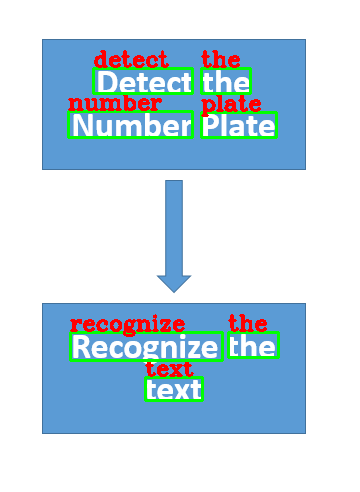

In [51]:
cv2_imshow(img_copy)